In [ ]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
import torch.autograd as grad
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from __future__ import print_function

Finding Mean and Standard Deviation of the MNIST Datset so that we can Normalize the Data.

In [ ]:
# Finding Mean and Standard Deviation of the MNIST Datset so that we can Normalize the Data.
simple_transform = transforms.Compose([transforms.ToTensor()])
sample_data = datasets.MNIST(root = './data', train = True, download = True, transform = simple_transform)

sample_data = sample_data.transform(sample_data.data.numpy())
print('Shape of the Dataset : ', sample_data.size())
print('Mean of the Dataset : ', torch.mean(sample_data))
print('Standard Deviation of the Dataset : ', torch.std(sample_data))
print('Variance of the Dataset : ', torch.var(sample_data))
print('Minimum of the Dataset : ', torch.min(sample_data))
print('Maximum of the Dataset : ', torch.max(sample_data))

Shape of the Dataset :  torch.Size([28, 60000, 28])
Mean of the Dataset :  tensor(0.1307)
Standard Deviation of the Dataset :  tensor(0.3081)
Variance of the Dataset :  tensor(0.0949)
Minimum of the Dataset :  tensor(0.)
Maximum of the Dataset :  tensor(1.)


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.RandomAffine((-8.0, 8.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g. tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([                                    
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST(root = './data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST(root = './data', train = False, download = True, transform = test_transforms)

In [ ]:
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
  torch.manual_seed(SEED)
data_loader_args = dict(shuffle = True, batch_size = 128, num_workers = 2, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 64)
train_loader = DataLoader(train, **data_loader_args)
test_loader = DataLoader(test, **data_loader_args)

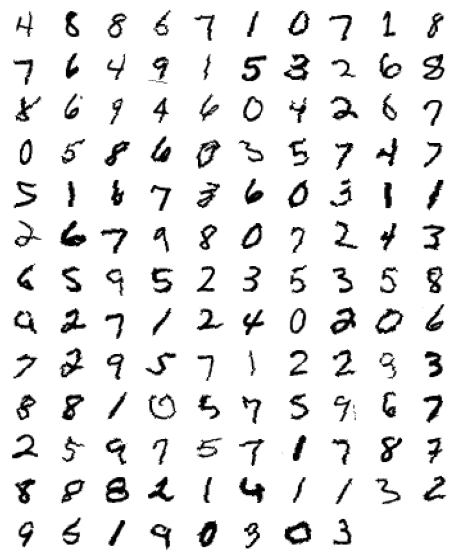

In [ ]:
batch = next(iter(train_loader))
images, labels = batch
fig = plt.figure(figsize=(8, 10))
for image_no in range(1, images.shape[0] + 1):
  plt.subplot(13, 10, image_no)
  plt.axis('off')
  plt.imshow(images[image_no - 1].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Network(nn.Module):
  def __init__(self): 
    super(Network, self).__init__()
    # Convolution Block 1
    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(16)) # RF = (1 + (3 - 1) * 1) => 3 || I/P = 28*28, O/P = 28*28
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3,3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(24)) # RF = (3 + (3 - 1) * 1) => 5 || I/P = 28*28, O/P = 28*28
    # Transition Block 1
    self.maxpool1 = nn.MaxPool2d(2, 2) # RF = (5 + (2 - 1) * 1) => 6 || I/P = 28*28, O/P = 14*14
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=24, out_channels=8, kernel_size=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(8)) # RF = 6 || I/P = 14*14*24, O/P = 14*14*8
    # Convolution Block 2
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(16)) # RF = (6 + (3 - 1) * 2) => 10 || I/P = 14*14, O/P = 14*14
    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1), 
                                    nn.ReLU(),
                                    nn.BatchNorm2d(16),
                                    nn.Dropout(0.1)) # RF = (10 + (3 - 1) * 2) => 14 || I/P = 14*14, O/P = 14*14
    # Transition Block 2
    self.maxpool2 = nn.MaxPool2d(2, 2) # RF = (10 + (2 - 1) * 2) => 14 || I/P = 14*14, O/P = 7*7
    # Output Block --> Gap + 1*1 convolution
    self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=7)) # RF = (14 + (7 - 1) * 4) => 38 || I/P = 7*7*16, O/P = 1*1*16
    self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1,1))) # RF = 38, I/P = 1*1*16, O/P = 1*1*10

  def forward(self, tensor):
    # Input Layer
    x = tensor
    # Block 1
    x = self.convblock1(x)
    x = self.convblock2(x)
    # Transition Block 1
    x = self.maxpool1(x)
    x = self.convblock3(x)
    # Block 2
    x = self.convblock4(x)
    x = self.convblock5(x)
    # Transition Block 2
    x = self.maxpool2(x)
    # x = self.convblock6(x)
    # Output Block
    x = self.gap(x)
    x = self.convblock6(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)
sample = Network().to(device)
summary(sample, input_size = (1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 24, 28, 28]           3,480
              ReLU-5           [-1, 24, 28, 28]               0
       BatchNorm2d-6           [-1, 24, 28, 28]              48
         MaxPool2d-7           [-1, 24, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]             200
              ReLU-9            [-1, 8, 14, 14]               0
      BatchNorm2d-10            [-1, 8, 14, 14]              16
           Conv2d-11           [-1, 16, 14, 14]           1,168
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
           Conv2d-14           [-1

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR
model =  Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
device = torch.device('cuda' if use_cuda else 'cpu')
EPOCHS = 15
for epoch in range(1, EPOCHS + 1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.11238285154104233 Batch_id=468 Accuracy=89.49: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]



Test set: Average loss: 0.0819, Accuracy: 9738/10000 (97.38%)

EPOCH: 2


Loss=0.1696108728647232 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]



Test set: Average loss: 0.1067, Accuracy: 9657/10000 (96.57%)

EPOCH: 3


Loss=0.018546422943472862 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]



Test set: Average loss: 0.0655, Accuracy: 9779/10000 (97.79%)

EPOCH: 4


Loss=0.06569243222475052 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0641, Accuracy: 9797/10000 (97.97%)

EPOCH: 5


Loss=0.07154252380132675 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:21<00:00, 21.73it/s]



Test set: Average loss: 0.0500, Accuracy: 9845/10000 (98.45%)

EPOCH: 6


Loss=0.11498161405324936 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]



Test set: Average loss: 0.0484, Accuracy: 9846/10000 (98.46%)

EPOCH: 7


Loss=0.024339944124221802 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:21<00:00, 21.87it/s]



Test set: Average loss: 0.0676, Accuracy: 9771/10000 (97.71%)

EPOCH: 8


Loss=0.00745089165866375 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]



Test set: Average loss: 0.0563, Accuracy: 9827/10000 (98.27%)

EPOCH: 9


Loss=0.03159410133957863 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:21<00:00, 21.78it/s]



Test set: Average loss: 0.0454, Accuracy: 9858/10000 (98.58%)

EPOCH: 10


Loss=0.057092905044555664 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]



Test set: Average loss: 0.0418, Accuracy: 9856/10000 (98.56%)

EPOCH: 11


Loss=0.06214803457260132 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]



Test set: Average loss: 0.0355, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.24066650867462158 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]



Test set: Average loss: 0.0430, Accuracy: 9854/10000 (98.54%)

EPOCH: 13


Loss=0.023733511567115784 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s]



Test set: Average loss: 0.0398, Accuracy: 9865/10000 (98.65%)

EPOCH: 14


Loss=0.048726607114076614 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]



Test set: Average loss: 0.0338, Accuracy: 9896/10000 (98.96%)

EPOCH: 15


Loss=0.024405164644122124 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 20.68it/s]



Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

